In [1]:
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

# Set the source and destination paths
source_path = '/content/drive/MyDrive/ML4T/assets.h5'
destination_path = '/content/data/assets.h5'

# Create the destination directory if it doesn't exist
os.makedirs(os.path.dirname(destination_path), exist_ok=True)

# Copy the file
!cp "{source_path}" "{destination_path}"

print(f"File copied from {source_path} to {destination_path}")

Mounted at /content/drive
File copied from /content/drive/MyDrive/ML4T/assets.h5 to /content/data/assets.h5


# How to use TA-Lib to generate Alpha Factors

Technical analysis is a popular method for analyzing financial markets and generating trading signals. TA-Lib (Technical Analysis Library) is a powerful open-source library that provides a wide range of technical indicators and chart pattern recognition tools. In this notebook, we'll explore how to use TA-Lib to generate alpha factors, which are signals that can potentially predict future asset returns.

We'll cover the following topics:

1. Setting up the environment and importing necessary libraries
2. Loading and preparing financial data
3. Applying TA-Lib functions to compute technical indicators
4. Visualizing the results

Let's start by importing the required libraries and setting up our environment.

In [4]:
url = 'https://anaconda.org/conda-forge/libta-lib/0.4.0/download/linux-64/libta-lib-0.4.0-h166bdaf_1.tar.bz2'
!curl -L $url | tar xj -C /usr/lib/x86_64-linux-gnu/ lib --strip-components=1
url = 'https://anaconda.org/conda-forge/ta-lib/0.4.19/download/linux-64/ta-lib-0.4.19-py310hde88566_4.tar.bz2'
!curl -L $url | tar xj -C /usr/local/lib/python3.10/dist-packages/ lib/python3.10/site-packages/talib --strip-components=3
import talib

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4095    0  4095    0     0   8700      0 --:--:-- --:--:-- --:--:--  8694
100  517k  100  517k    0     0   404k      0  0:00:01  0:00:01 --:--:--  404k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4131    0  4131    0     0   9564      0 --:--:-- --:--:-- --:--:--  9562
100  392k  100  392k    0     0   332k      0  0:00:01  0:00:01 --:--:-- 2979k


In [5]:
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

from datetime import datetime
import pandas as pd
import pandas_datareader.data as web

# Import specific TA-Lib functions
from talib import RSI, BBANDS, MACD

import matplotlib.pyplot as plt
import seaborn as sns

# Set up Seaborn style for better-looking plots
sns.set_style('whitegrid')

# Define a shorthand for pandas' IndexSlice
idx = pd.IndexSlice

## Get Data

The `assets.h5` store can be generated using the notebook [create_datasets](../../data/create_datasets.ipynb) in the [data](../../data) directory in the root directory of this repo for instruction to download the following dataset.

We load the AAPL stock price for the 2007-10 using `pd.IndexSlice` to perform a slice operation on the `pd.MultiIndex`, select the adjusted close price and unpivot the column to convert the DataFrame to wide format with tickers in the columns and timestamps in the rows:

Set data store location:

In [8]:
import os
from pathlib import Path

# Set the path to the HDF5 data store
DATA_STORE = '/content/data/assets.h5'

# Create the directory if it doesn't exist
os.makedirs(os.path.dirname(DATA_STORE), exist_ok=True)

# Check if the file exists
if not os.path.exists(DATA_STORE):
    print(f"Error: The file {DATA_STORE} does not exist.")
    print("Please ensure you've downloaded the file correctly.")
else:
    # If the file exists, proceed with opening it
    with pd.HDFStore(DATA_STORE) as store:
        data = (store['quandl/wiki/prices']
                .loc[idx['2007':'2010', 'AAPL'],
                     ['adj_open', 'adj_high', 'adj_low', 'adj_close', 'adj_volume']]
                .unstack('ticker')
                .swaplevel(axis=1)
                .loc[:, 'AAPL']
                .rename(columns=lambda x: x.replace('adj_', '')))

    # Print information about the resulting DataFrame
    data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1008 entries, 2007-01-03 to 2010-12-31
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    1008 non-null   float64
 1   high    1008 non-null   float64
 2   low     1008 non-null   float64
 3   close   1008 non-null   float64
 4   volume  1008 non-null   float64
dtypes: float64(5)
memory usage: 47.2 KB


## Compute Bollinger Bands

Bollinger Bands are a popular technical analysis tool invented by John Bollinger in the 1980s. They consist of three lines:

1. A middle band - typically a 20-day simple moving average (SMA)
2. An upper band - usually 2 standard deviations above the middle band
3. A lower band - usually 2 standard deviations below the middle band

Bollinger Bands are used to measure volatility and identify "overbought" or "oversold" conditions. They are based on the notion that:

- Prices tend to stay within the upper and lower bands
- When prices move closer to the upper band, it may indicate an overbought market
- When prices move closer to the lower band, it may indicate an oversold market
- The distance between the bands widens during periods of high volatility and narrows during periods of low volatility

Key interpretations:

- Trend Strength: When prices consistently touch one band, it often indicates a strong trend in that direction.
- Breakouts: When the price breaks above or below the bands, it can signal a potential continuation of the current trend.
- Mean Reversion: Prices often bounce off the bands and move back towards the middle band.
- Squeeze: When the bands come very close together, it often precedes a period of high volatility.

In the following code, we'll use TA-Lib to calculate Bollinger Bands for our AAPL stock data. We'll use a 21-day period (approximately one trading month) and 2 standard deviations for the upper and lower bands.

In [9]:
# Compute Bollinger Bands using TA-Lib
up, mid, low = BBANDS(data.close, timeperiod=21, nbdevup=2, nbdevdn=2, matype=0)

# Print the first few rows of the Bollinger Bands
print(pd.DataFrame({'Upper': up, 'Middle': mid, 'Lower': low}).head())

            Upper  Middle  Lower
date                            
2007-01-03    NaN     NaN    NaN
2007-01-04    NaN     NaN    NaN
2007-01-05    NaN     NaN    NaN
2007-01-08    NaN     NaN    NaN
2007-01-09    NaN     NaN    NaN


## Compute Relative Strength Index

The Relative Strength Index (RSI) is a momentum oscillator developed by J. Welles Wilder Jr. in 1978. It measures the speed and change of price movements, oscillating between 0 and 100. The RSI is computed using the following steps:

1. Calculate the average gain and average loss over a specified period (typically 14 days).
2. Compute the relative strength (RS) as the ratio of average gain to average loss.
3. Apply the RSI formula: RSI = 100 - (100 / (1 + RS))

Key interpretations of RSI:

- Overbought/Oversold: Traditionally, RSI values over 70 indicate an overbought condition, while values under 30 suggest an oversold condition. These thresholds can be adjusted based on the specific asset and market conditions.

- Divergence: When the price makes a new high or low that isn't confirmed by the RSI, it's called divergence and can signal a potential reversal.

- Centerline Crossover: Crossing above 50 is considered bullish, while crossing below 50 is considered bearish.

- Failure Swings: These are reversal signals that occur when RSI doesn't reach 70 in an uptrend (or 30 in a downtrend) and then breaks its recent low (or high).

RSI is particularly useful for:
- Identifying potential entry and exit points
- Confirming trends
- Spotting potential reversals

In the following code, we'll use TA-Lib to calculate the RSI for our AAPL stock data using the standard 14-day period.

date
2007-01-03   NaN
2007-01-04   NaN
2007-01-05   NaN
2007-01-08   NaN
2007-01-09   NaN
Name: RSI, dtype: float64


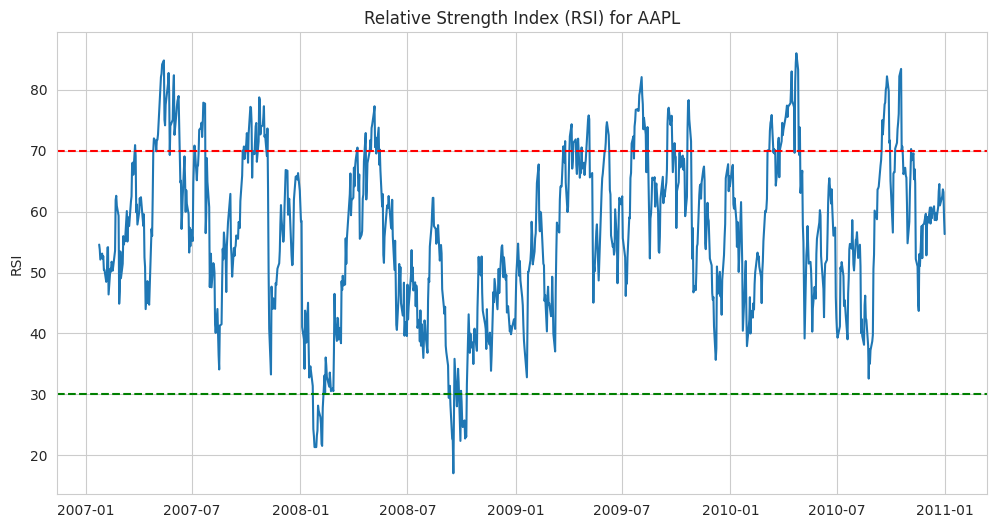

In [10]:
# Compute Relative Strength Index (RSI) using TA-Lib
rsi = RSI(data.close, timeperiod=14)

# Print the first few values of the RSI
print(pd.Series(rsi, name='RSI').head())

# Plot the RSI
plt.figure(figsize=(12, 6))
plt.plot(data.index, rsi)
plt.title('Relative Strength Index (RSI) for AAPL')
plt.axhline(y=70, color='r', linestyle='--')
plt.axhline(y=30, color='g', linestyle='--')
plt.ylabel('RSI')
plt.show()

## Moving Average Convergence/Divergence

The Moving Average Convergence/Divergence (MACD) is a trend-following momentum indicator developed by Gerald Appel in the late 1970s. It's one of the simplest and most effective momentum indicators available. The MACD turns two trend-following indicators, moving averages, into a momentum oscillator by subtracting the longer moving average from the shorter moving average.

The MACD consists of three components:

1. MACD Line: The difference between two exponential moving averages (EMAs), typically the 12-day and 26-day EMAs.
2. Signal Line: Usually a 9-day EMA of the MACD Line.
3. MACD Histogram: The difference between the MACD Line and the Signal Line.

Key interpretations of MACD:

- Crossovers: When the MACD Line crosses above the Signal Line, it's a bullish signal, and when it crosses below, it's bearish.
- Divergence: When the MACD diverges from the price action, it can signal a potential reversal.
- Dramatic Rise/Fall: When the MACD rises or falls dramatically, it suggests overbought or oversold conditions.

The MACD is particularly useful for:
- Identifying trend direction and strength
- Spotting potential trend reversals
- Generating buy/sell signals

In the following code, we'll use TA-Lib to calculate the MACD for our AAPL stock data using the standard settings (12-day and 26-day EMAs for the MACD Line, 9-day EMA for the Signal Line).

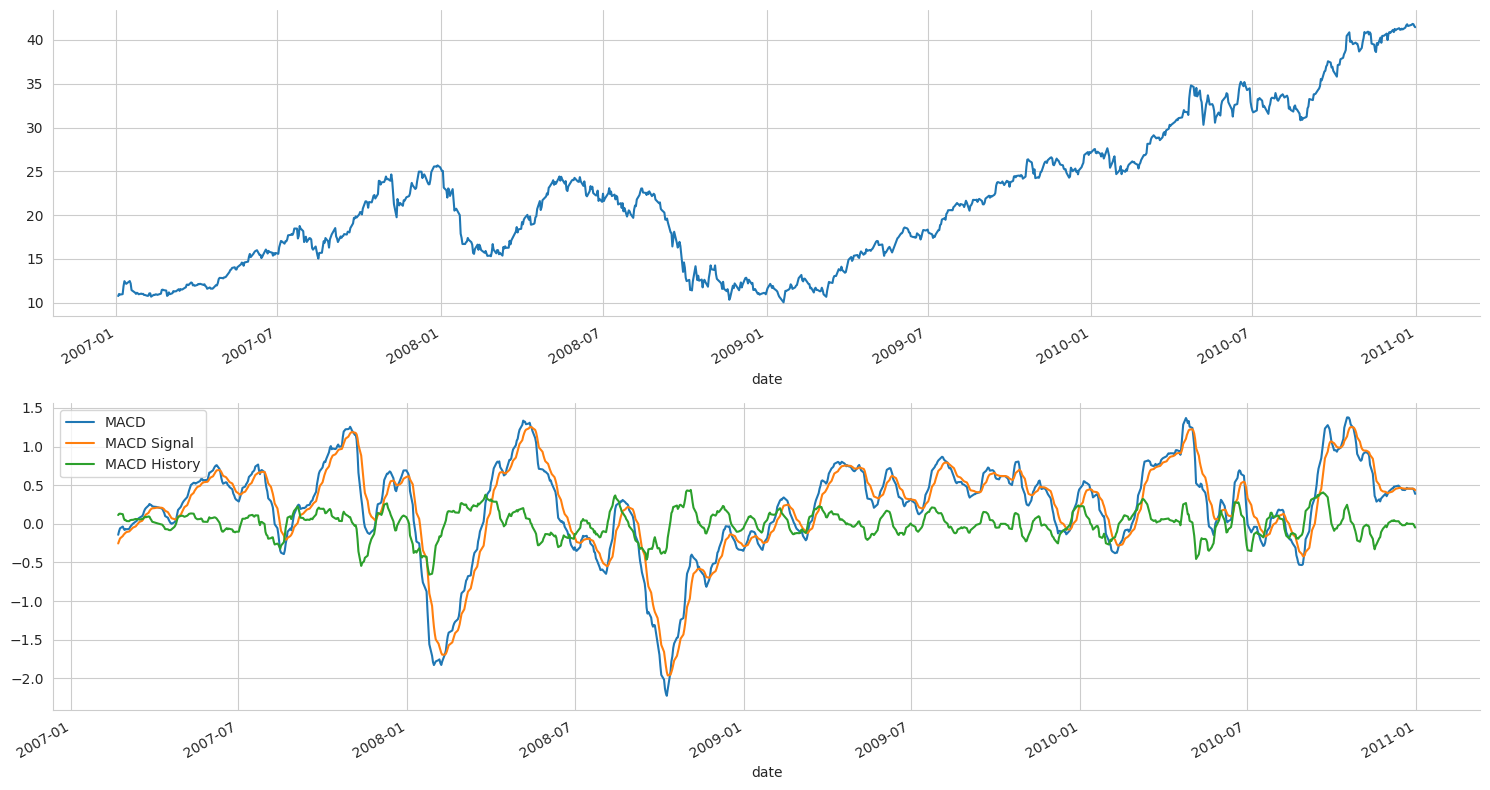

In [12]:
# Compute MACD using TA-Lib
macd, macdsignal, macdhist = MACD(data.close, fastperiod=12, slowperiod=26, signalperiod=9)

# Create a DataFrame with AAPL close price and MACD components
macd_data = pd.DataFrame({'AAPL': data.close, 'MACD': macd, 'MACD Signal': macdsignal, 'MACD History': macdhist})

# Create the plot
fig, axes= plt.subplots(nrows=2, figsize=(15, 8))

# Plot AAPL close price
macd_data.AAPL.plot(ax=axes[0])

# Plot MACD components
macd_data.drop('AAPL', axis=1).plot(ax=axes[1])

# Adjust the layout and remove spines
fig.tight_layout()
sns.despine()

## Plot Result

Now that we have calculated the Bollinger Bands, RSI, and MACD for our AAPL stock data, let's combine these indicators into a single DataFrame and create a comprehensive visualization. This will allow us to see how these different technical indicators relate to each other and to the stock price over time.

We'll create a plot with three subplots:
1. The stock price with Bollinger Bands
2. The Relative Strength Index (RSI)
3. The Moving Average Convergence/Divergence (MACD)

This combined view will give us a more complete picture of the stock's behavior and potential trading signals.

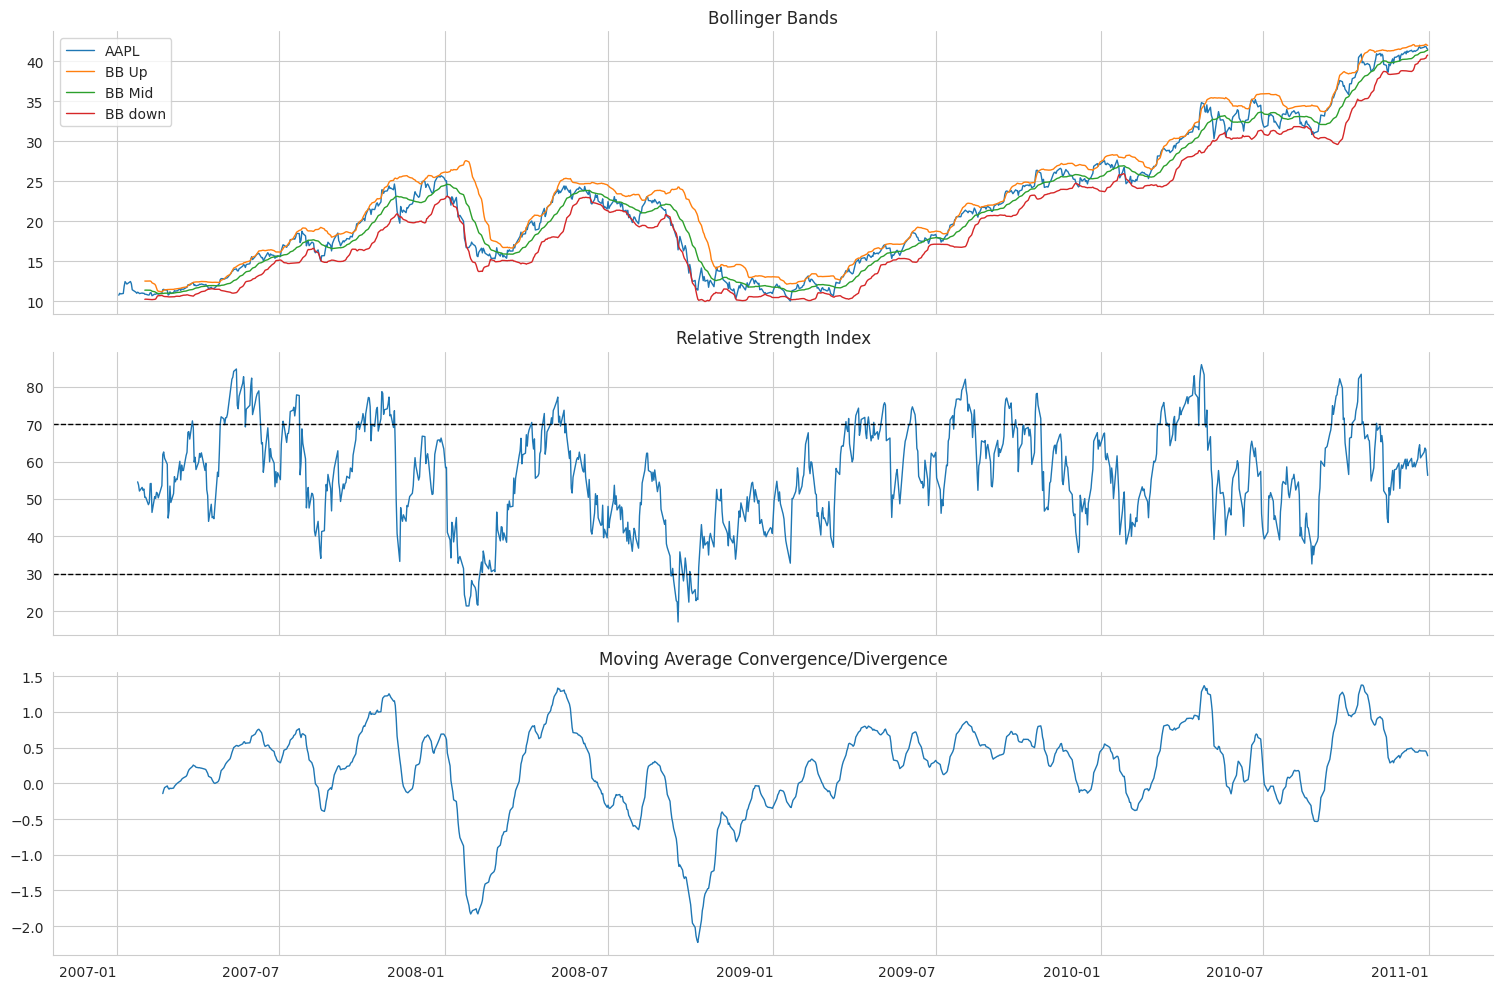

In [13]:
# Combine all indicators into a single DataFrame
data = pd.DataFrame({'AAPL': data.close, 'BB Up': up, 'BB Mid': mid, 'BB down': low, 'RSI': rsi, 'MACD': macd})

# Create the plot
fig, axes= plt.subplots(nrows=3, figsize=(15, 10), sharex=True)

# Plot Bollinger Bands
data.drop(['RSI', 'MACD'], axis=1).plot(ax=axes[0], lw=1, title='Bollinger Bands')

# Plot RSI
data['RSI'].plot(ax=axes[1], lw=1, title='Relative Strength Index')
axes[1].axhline(70, lw=1, ls='--', c='k')
axes[1].axhline(30, lw=1, ls='--', c='k')

# Plot MACD
data.MACD.plot(ax=axes[2], lw=1, title='Moving Average Convergence/Divergence', rot=0)
axes[2].set_xlabel('')

# Adjust layout and remove spines
fig.tight_layout()
sns.despine()